In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
from flowFieldWavy import *
from flowFieldArray import *
from pseudo import *
from laminar import *
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse.linalg import LinearOperator,gmres

figureFolder = '/home/sabarish/Dropbox/reports/2016/JFM/figures/'
docFolder ='./doc/figures/'



In [164]:
flowDict = getDefaultDict()
flowDict.update({'K':0,'L':8,'M':0,'N':35,'Re':100.,'alpha':10.,'beta':0.,'eps':0.01,'isPois':1})
flowDictFlat = updateDict(flowDict, {'eps':0.})

vfFlat = dict2ff(flowDictFlat)
vfFlat[0,vfFlat.nx//2, 0,0] *= 0.998
vfFlat[0,vfFlat.nx//2+1, 0,1] += 0.01*(1.-vfFlat.y**2)+0.001*(1.-vfFlat.y**4)
vfFlat[0,vfFlat.nx//2+1, 0,1] = -vfFlat[0,vfFlat.nx//2-1, 0,1]
J,F = makeSystem(flowDict=flowDict,resNorm=False)
print(J.shape, F.shape)

w = clencurt(flowDict['N'])
wRoot = np.sqrt(w)
wRootMat = np.diag(np.repeat(wRoot, (F.size//flowDict['N'])))
J = np.dot(wRootMat, J)
F = np.dot(wRootMat, F)


JFlat,FFlat = makeSystem(vf=vfFlat,resNorm=False)

# Adding pressure BC on zeroth mode
L = vfFlat.nx//2; N = vfFlat.N
J[L*4*N+3*N,:] = 0. 
J[L*4*N+3*N,L*4*N+3*N] = 1. 
JFlat[L*4*N+3*N,:] = 0. 
JFlat[L*4*N+3*N,L*4*N+3*N] = 1. 



def getResNorm(res,normList):
    normList.append(np.linalg.norm(res))
    return 
    
def printResNorm(res):
    print(np.linalg.norm(res))
    return
    

(2380, 2380) (2380,)


/home/sabarish/Dropbox/gitwork/python3/flowFieldV2/laminar.py:454: UserWarning: pressure field not supplied, assigning zero pressure for computing residual
  warn('pressure field not supplied, assigning zero pressure for computing residual')


## Eigenvalues without preconditioning

In [150]:
evals, evecs = np.linalg.eig(J)
evalsFlat,evecsFlat = np.linalg.eig(JFlat)
cnEvecs = np.linalg.cond(evecs)
print('Evec condition number:', cnEvecs)

Evec condition number: 48345701641.4


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


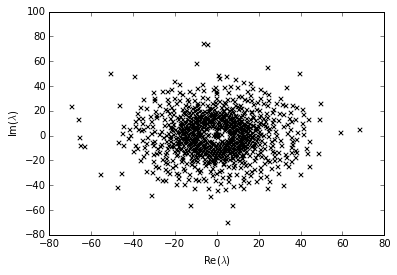

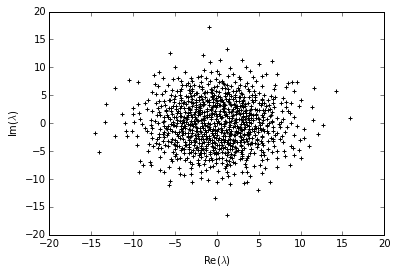

In [151]:
plt.figure()
plt.scatter(np.real(evalsFlat), np.imag(evalsFlat),marker='x',color='k',facecolors='none')
plt.xlabel("Re($\\lambda$)"); plt.ylabel("Im($\\lambda$)")
#plt.xlim([-1,1]);plt.ylim([-1,1])

#plt.savefig(docFolder+'flatEvals.pdf',format='pdf')
plt.show()


plt.figure()
plt.scatter(np.real(evals), np.imag(evals), marker='+', color='k', facecolors='none')
plt.xlabel("Re($\\lambda$)"); plt.ylabel("Im($\\lambda$)")
#plt.xlim([-5,5]);plt.ylim([-5,5])
#plt.savefig(docFolder+'wavyEvals.pdf',format='pdf')
plt.show()

In [141]:
sizeArr = np.arange(evals.size)
flatNearZero = sizeArr[np.abs(evalsFlat)<1]
wavyNearZero = sizeArr[np.abs(evals)<1]
flatNearZero.size, wavyNearZero.size, evals[wavyNearZero],evalsFlat[flatNearZero]

(18, 6, array([  5.99796159e-01 +1.59461322e-02j,
         -9.41998506e-01 +1.39175604e-01j,
          3.97746556e-03 -5.59458845e-04j,
          1.29448149e-06 -1.34775966e-07j,
         -1.29402901e-06 +1.34592020e-07j,   1.84200481e-13 -9.10311031e-13j]), array([ 0.53376590-0.2675822j , -0.29690978-0.47697219j,
        -0.55733991+0.15013778j,  0.21371011+0.4989411j ,
         0.13826155-0.0054978j ,  0.09230204-0.09828318j,
        -0.00233135-0.13510078j, -0.10180714-0.09225865j,
         0.09875458+0.09485711j, -0.13344102+0.01429544j,
        -0.07968999+0.09839118j,  0.00424438+0.12767487j,
        -0.01173326+0.07644634j,  0.05824096+0.04687841j,
         0.06958393-0.02659447j, -0.07293807+0.02435905j,
         0.01230445-0.07203025j, -0.05532038-0.04899948j]))

2380


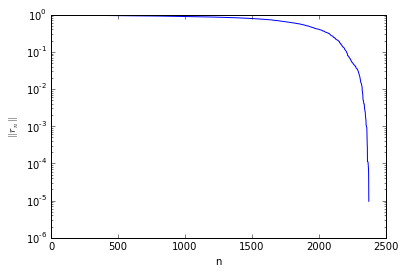

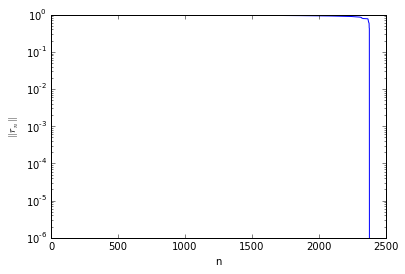

In [165]:
rnorm0 = []; getNorm0 = lambda res: getResNorm(res,rnorm0)
dx0,info0 = gmres(J, -F, restart = F.size,callback=getNorm0)
print(F.size)

rnorm0Flat = []; getNorm0Flat = lambda res: getResNorm(res,rnorm0Flat)
dx0Flat,info0Flat = gmres(JFlat, -FFlat, restart = FFlat.size,callback=getNorm0Flat)

plt.plot(rnorm0); 
plt.yscale("log"); plt.xlabel("n"); plt.ylabel("$||r_n||$")
plt.ylim([1.0e-6,1.0])
#plt.savefig(docFolder+'gmresNorm0wavy_noPre.pdf',format='pdf')
plt.show()

plt.plot(rnorm0Flat); 
plt.yscale("log"); plt.xlabel("n"); plt.ylabel("$||r_n||$")
plt.ylim([1.0e-6,1.0])
#plt.savefig(docFolder+'gmresNorm0flat_noPre.pdf',format='pdf')
plt.show()


## Preconditioner based on Jacobian-diagonal

In [68]:
Mdiag = np.diag(J)
MdiagFlat = np.diag(JFlat)
print(Mdiag.shape, MdiagFlat.shape)
Mdiag = np.diag(Mdiag)
MdiagFlat = np.diag(MdiagFlat)
print(Mdiag.shape, MdiagFlat.shape)

(924,) (924,)
(924, 924) (924, 924)


In [69]:
Mdiag[np.abs(Mdiag)< 1.0e-6] = 1.
MdiagFlat[np.abs(MdiagFlat)< 1.0e-06] = 1.


In [70]:
MdiagInv = 1./Mdiag
MdiagFlatInv = 1./MdiagFlat

In [116]:
evals, evecs = np.linalg.eig(np.dot(J,MdiagInv))
evalsFlat,evecsFlat = np.linalg.eig(np.dot(JFlat,MdiagFlatInv))
cnEvecs = np.linalg.cond(evecs)
print('Evec condition number:', cnEvecs)

Evec condition number: 4.273380189e+18


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


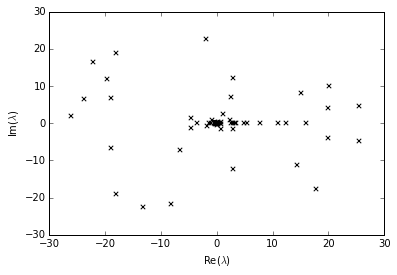

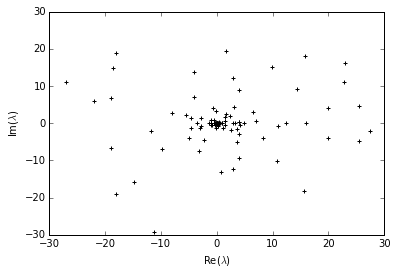

In [73]:
plt.figure()
plt.scatter(np.real(evalsFlat), np.imag(evalsFlat),marker='x',color='k',facecolors='none')
plt.xlabel("Re($\\lambda$)"); plt.ylabel("Im($\\lambda$)")
plt.xlim([-30,30]); plt.ylim([-30,30])
plt.savefig(docFolder+'flatEvals_JDiagZoom.pdf',format='pdf')
plt.show()


plt.figure()
plt.scatter(np.real(evals), np.imag(evals), marker='+', color='k', facecolors='none')
plt.xlabel("Re($\\lambda$)"); plt.ylabel("Im($\\lambda$)")
plt.xlim([-30,30]); plt.ylim([-30,30])
plt.savefig(docFolder+'wavyEvals_JDiagZoom.pdf',format='pdf')
plt.show()

In [76]:
sizeArr = np.arange(evals.size)
flatNearZero = sizeArr[np.abs(evalsFlat)<1.0e-6]
wavyNearZero = sizeArr[np.abs(evals)<1.0e-6]
flatNearZero.size, wavyNearZero.size, evals[wavyNearZero[-10:]],evalsFlat[flatNearZero[-10:]]

(717, 650, array([ -3.18416439e-081 +4.21821472e-082j,
          3.38450346e-095 -1.72870621e-095j,
          4.56347280e-096 -1.07240599e-095j,
          2.85100600e-097 +2.87445804e-096j,
         -3.67561738e-096 +2.02572459e-096j,
         -5.70124230e-097 -1.04571199e-098j,
         -3.15367879e-111 +1.75302652e-111j,
          2.47895340e-112 -1.54660530e-112j,
          5.01743379e-113 -5.57853877e-114j,
          6.32741491e-127 +1.35887942e-126j]), array([  2.89963855e-096 +1.58050453e-096j,
          8.02999259e-097 +9.86747229e-097j,
          1.17440231e-098 -2.24259430e-098j,
          8.94816179e-108 +2.85381987e-108j,
          3.57165476e-113 +4.93439140e-113j,
         -8.50152135e-114 -2.12097857e-114j,
          8.98544017e-116 +6.61518194e-116j,
         -2.26675596e-125 +5.75945651e-126j,
         -1.05459416e-130 +3.05290775e-130j,
          0.00000000e+000 +0.00000000e+000j]))

In [79]:
evals, evecs = np.linalg.eig(Mdiag)
evalsFlat,evecsFlat = np.linalg.eig(MdiagFlat)

In [78]:
sizeArr = np.arange(evals.size)
flatNearZero = sizeArr[np.abs(evalsFlat)<1.0e-6]
wavyNearZero = sizeArr[np.abs(evals)<1.0e-6]
flatNearZero.size, wavyNearZero.size, evals[wavyNearZero[-10:]],evalsFlat[flatNearZero[-10:]]

(749, 682, array([  1.65978404e-200 +2.66562943e-200j,
         -7.55646282e-206 -5.49149839e-206j,
          3.87031442e-213 -7.38374319e-213j,
         -1.08754008e-215 +3.36260250e-215j,
          2.49665521e-218 +2.09324000e-218j,
         -2.03063055e-225 -1.25173987e-225j,
         -6.34827188e-231 -3.82197142e-232j,
         -2.57194294e-233 +1.81590551e-233j,
          2.03581033e-238 +5.45525852e-238j,
         -1.48319681e-245 -1.17612379e-245j]), array([ -2.20832557e-091 -8.54237247e-108j,
          2.92585654e-094 -2.80968018e-107j,
         -3.70637571e-098 -3.59495195e-114j,
          5.97629991e-100 -7.77749227e-115j,
         -6.09868796e-107 +1.00041746e-105j,
         -6.09868796e-107 -1.00041746e-105j,
          4.67260411e-107 -2.73970650e-121j,
         -1.51663533e-115 -5.62292514e-132j,
         -9.66405429e-122 +1.07445103e-137j,
         -1.05608370e-122 +1.83141249e-139j]))

(924, 924) 924


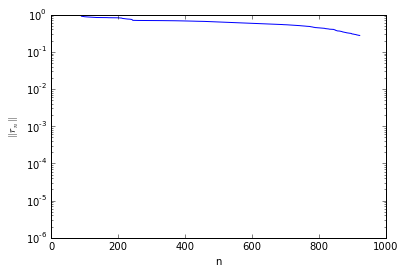

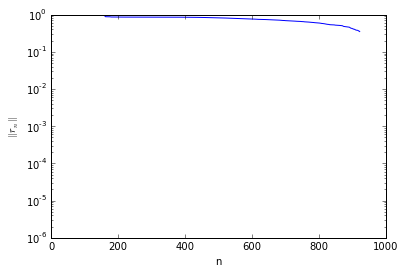

In [127]:
rnorm0 = []; getNorm0 = lambda res: getResNorm(res,rnorm0)
dx0,info0 = gmres(np.dot(J,MdiagInv), -F, restart = F.size,maxiter=F.size-1,callback=getNorm0)
print(np.dot(J,MdiagInv).shape, F.size)

rnorm0Flat = []; getNorm0Flat = lambda res: getResNorm(res,rnorm0Flat)
dx0Flat,info0Flat = gmres(np.dot(JFlat,MdiagFlatInv), -FFlat, restart = FFlat.size, maxiter=FFlat.size-1,callback=getNorm0Flat)

plt.plot(rnorm0); 
plt.yscale("log"); plt.xlabel("n"); plt.ylabel("$||r_n||$")
plt.ylim([1.0e-6,1.0])
plt.savefig(docFolder+'gmresNorm0wavy_Jdiag.pdf',format='pdf')
plt.show()

plt.plot(rnorm0Flat); 
plt.yscale("log"); plt.xlabel("n"); plt.ylabel("$||r_n||$")
plt.ylim([1.0e-6,1.0])
plt.savefig(docFolder+'gmresNorm0flat_Jdiag.pdf',format='pdf')
plt.show()

## Linear operator based preconditioner

In [166]:
Lmat = linr(flowDict)
LmatFlat = linr(flowDictFlat)
nx = 2*flowDict['L'] + 1; N = flowDict['N']
BCrows = 4*N*np.arange(nx).reshape((nx,1)) + np.array([0,N-1,N,2*N-1,2*N,3*N-1]).reshape((1,6))
BCrows = BCrows.flatten()

Lmat[BCrows,:] = 0.; Lmat[BCrows,BCrows] = 1.
LmatFlat[BCrows,:] = 0.; LmatFlat[BCrows,BCrows] = 1.

LmatInv = np.linalg.pinv(Lmat)
LmatFlatInv = np.linalg.pinv(LmatFlat)

In [154]:
evals, evecs = np.linalg.eig(np.dot(J,LmatInv))
evalsFlat,evecsFlat = np.linalg.eig(np.dot(JFlat,LmatFlatInv))
cnEvecs = np.linalg.cond(evecs)
print('Evec condition number:', cnEvecs)

Evec condition number: 8678535014.3


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


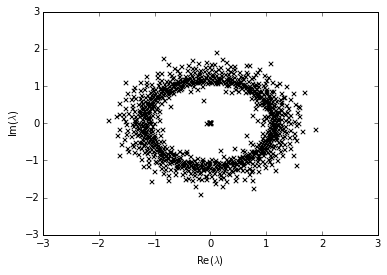

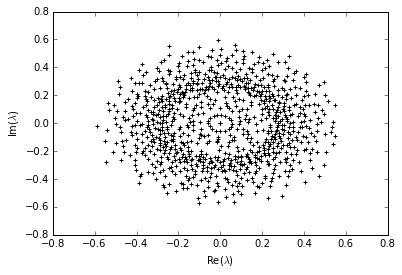

In [155]:
lims = 30
plt.figure()
plt.scatter(np.real(evalsFlat), np.imag(evalsFlat),marker='x',color='k',facecolors='none')
plt.xlabel("Re($\\lambda$)"); plt.ylabel("Im($\\lambda$)")
#plt.xlim([-lims,lims]); plt.ylim([-lims,lims])
#plt.savefig(docFolder+'flatEvals_Lmat.pdf',format='pdf')
plt.show()


plt.figure()
plt.scatter(np.real(evals), np.imag(evals), marker='+', color='k', facecolors='none')
plt.xlabel("Re($\\lambda$)"); plt.ylabel("Im($\\lambda$)")
#plt.xlim([-lims,lims]); plt.ylim([-lims,lims])
#plt.savefig(docFolder+'wavyEvals_Lmat.pdf',format='pdf')
plt.show()

In [86]:
sizeArr = np.arange(evals.size)
flatNearZero = sizeArr[np.abs(evalsFlat)<0.2]
wavyNearZero = sizeArr[np.abs(evals)<0.2]
flatNearZero.size, wavyNearZero.size, evals[wavyNearZero[-10:]],evalsFlat[flatNearZero[-10:]]

(10, 3, array([  1.99355135e-07 +1.43242351e-07j,
         -1.99356196e-07 -1.43242153e-07j,   1.31104512e-15 +4.96068391e-16j]), array([ -5.44684910e-02 -8.92342231e-03j,
         -8.79469862e-03 -1.29718809e-02j,
         -1.54612120e-02 -1.55777253e-03j,
          3.66422893e-03 -1.47414466e-02j,
          1.27276699e-02 -7.08589774e-03j,
          1.30963480e-02 +4.05021133e-03j,
         -1.02894149e-02 +9.69474719e-03j,
          5.96083259e-03 +1.06516526e-02j,
         -9.06878720e-04 +1.19627437e-02j,   4.93131338e-14 +2.97059436e-14j]))

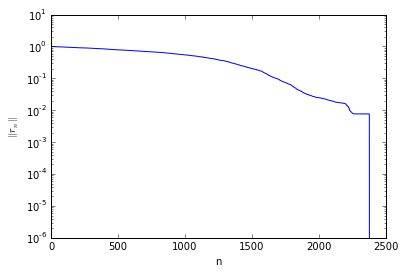

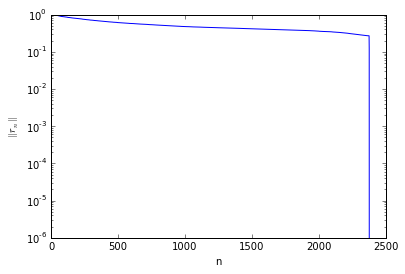

In [167]:
rnorm0 = []; getNorm0 = lambda res: getResNorm(res,rnorm0)
dx0,info0 = gmres(np.dot(J,LmatInv), -F, restart = F.size,callback=getNorm0)

rnorm0Flat = []; getNorm0Flat = lambda res: getResNorm(res,rnorm0Flat)
dx0Flat,info0Flat = gmres(np.dot(JFlat,LmatFlatInv), -FFlat, restart = FFlat.size,callback=getNorm0Flat)

plt.plot(rnorm0); 
plt.yscale("log"); plt.xlabel("n"); plt.ylabel("$||r_n||$")
plt.ylim([1.0e-6,10.0])
plt.savefig(docFolder+'gmresNorm0wavy_Lmat.pdf',format='pdf')
plt.show()

plt.plot(rnorm0Flat); 
plt.yscale("log"); plt.xlabel("n"); plt.ylabel("$||r_n||$")
plt.ylim([1.0e-6,1.0])
plt.savefig(docFolder+'gmresNorm0flat_Lmat.pdf',format='pdf')
plt.show()

## Coarse laminar operator based preconditioner

In [135]:
Lmat = linr(flowDict)
LmatFlat = linr(flowDictFlat)
nx = 2*flowDict['L'] + 1; N = flowDict['N']
BCrows = 4*N*np.arange(nx).reshape((nx,1)) + np.array([0,N-1,N,2*N-1,2*N,3*N-1]).reshape((1,6))
BCrows = BCrows.flatten()

Lmat[BCrows,:] = 0.; Lmat[BCrows,BCrows] = 1.
LmatFlat[BCrows,:] = 0.; LmatFlat[BCrows,BCrows] = 1.

LmatCoarse = Lmat[2*4*N:9*4*N, 2*4*N:9*4*N]
LmatFlatCoarse = LmatFlat[2*4*N:9*4*N, 2*4*N:9*4*N]

LmatCoarseInv = np.linalg.pinv(LmatCoarse)
LmatFlatCoarseInv = np.linalg.pinv(LmatFlatCoarse)

LmatInv = np.identity(Lmat.shape[0], dtype=np.complex)
LmatFlatInv = np.identity(Lmat.shape[0], dtype=np.complex)

LmatInv[2*4*N:9*4*N, 2*4*N:9*4*N] = LmatCoarseInv
LmatFlatInv[2*4*N:9*4*N, 2*4*N:9*4*N] = LmatFlatCoarseInv


In [136]:
evals, evecs = np.linalg.eig(np.dot(J,LmatInv))
evalsFlat,evecsFlat = np.linalg.eig(np.dot(JFlat,LmatFlatInv))
cnEvecs = np.linalg.cond(evecs)
print('Evec condition number:', cnEvecs)

Evec condition number: 20286101566.1


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


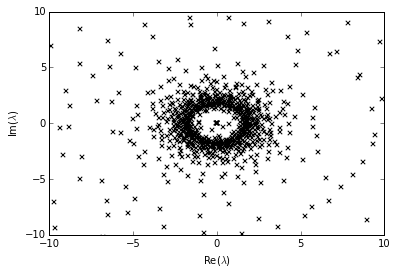

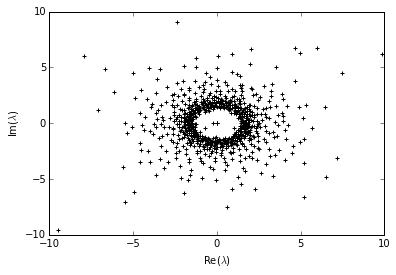

In [91]:
lims = 10
plt.figure()
plt.scatter(np.real(evalsFlat), np.imag(evalsFlat),marker='x',color='k',facecolors='none')
plt.xlabel("Re($\\lambda$)"); plt.ylabel("Im($\\lambda$)")
plt.xlim([-lims,lims]); plt.ylim([-lims,lims])
plt.savefig(docFolder+'flatEvals_LmatCoarseZoom.pdf',format='pdf')
plt.show()


plt.figure()
plt.scatter(np.real(evals), np.imag(evals), marker='+', color='k', facecolors='none')
plt.xlabel("Re($\\lambda$)"); plt.ylabel("Im($\\lambda$)")
plt.xlim([-lims,lims]); plt.ylim([-lims,lims])
plt.savefig(docFolder+'wavyEvals_LmatCoarseZoom.pdf',format='pdf')
plt.show()

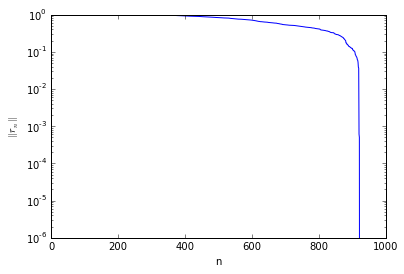

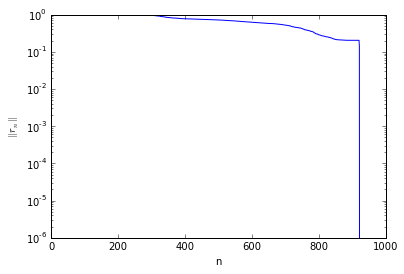

In [137]:
rnorm0 = []; getNorm0 = lambda res: getResNorm(res,rnorm0)
dx0,info0 = gmres(np.dot(J,LmatInv), -F, restart = F.size,callback=getNorm0)

rnorm0Flat = []; getNorm0Flat = lambda res: getResNorm(res,rnorm0Flat)
dx0Flat,info0Flat = gmres(np.dot(JFlat,LmatFlatInv), -FFlat, restart = FFlat.size,callback=getNorm0Flat)

plt.plot(rnorm0); 
plt.yscale("log"); plt.xlabel("n"); plt.ylabel("$||r_n||$")
plt.ylim([1.0e-6,1.0])
plt.savefig(docFolder+'gmresNorm0wavy_Lmat.pdf',format='pdf')
plt.show()

plt.plot(rnorm0Flat); 
plt.yscale("log"); plt.xlabel("n"); plt.ylabel("$||r_n||$")
plt.ylim([1.0e-6,1.0])
plt.savefig(docFolder+'gmresNorm0flat_Lmat.pdf',format='pdf')
plt.show()

In [ ]:
start = time.time()
x,_,rank,svals = np.linalg.lstsq(J,-F)
time.time()-start

In [ ]:
plt.plot(svals/svals[0]); plt.yscale("log");plt.show()

In [ ]:
np.min(np.arange(svals.size)[svals/svals[0]<1.0e-9]),svals.size

In [ ]:
Lmat0 = linr(flowDict); L = flowDict['L']; nx=2*L+1; N = flowDict['N']; N4 = 4*N
Lmat0.shape

In [ ]:
BCrows = N4*np.arange(nx).reshape((nx,1)) + np.array([0,N-1,N,2*N-1,2*N,3*N-1]).reshape((1,6))
BCrows = BCrows.flatten()

In [ ]:
LmatNoBC = np.delete(Lmat0,BCrows,axis=0)
LmatNoBC.shape, BCrows.shape

In [ ]:
addRows = np.zeros((BCrows.size,Lmat0.shape[1]),dtype=np.complex)
addRows[np.arange(BCrows.size),BCrows] = 1.
print(addRows.shape)
Lmat = np.append(LmatNoBC,addRows,axis=0)
LmatNoBC.shape, Lmat.shape, addRows.shape, BCrows.size

In [ ]:
LmatInv = np.linalg.pinv(Lmat)

In [ ]:
start = time.time()
x1,_,rank1,svals1 = np.linalg.lstsq(np.dot(J,LmatInv),-F)
time.time()-start

In [ ]:
plt.plot(svals1/svals1[0]); plt.yscale("log");plt.show()

In [ ]:
JPr = np.dot(J,LmatInv)
JPrFun = lambda xArr: np.dot(JPr,xArr)
JPrOp = LinearOperator(matvec=JPrFun, shape = (F.size,F.size), dtype=np.complex)
JFun = lambda xArr: np.dot(J,xArr)
JOp = LinearOperator( matvec= JFun, shape = (F.size, F.size), dtype=np.complex)

In [ ]:
start = time.time()
dx = gmres(JOp, -F,restart=F.size)
time.time()-start

In [ ]:
start = time.time()
dxPr = gmres(JPrOp, -F,restart=F.size)
time.time()-start

In [ ]:
dx0 = np.dot(LmatInv,dxPr[0])
np.linalg.norm(dx[0]-dx0)

In [ ]:
np.linalg.norm(np.dot(J,dx0)+F), np.linalg.norm(np.dot(J,dx[0])+F), np.linalg.norm(np.dot(J,dx[0]-dx0))

In [ ]:
np.linalg.norm(dx[0]),np.linalg.norm(dx0), np.linalg.norm(x-dx[0])

In [ ]:
null(J)

## Preconditioning with inverse of linear operator on a coarse grid

In [ ]:
flowDict0 = updateDict(flowDict,{'L':8}); dL = 0
Lmat0 = linr(flowDict0); L = flowDict0['L']; nx=2*L+1; N = flowDict0['N']; N4 = 4*N
BCrows = N4*np.arange(nx).reshape((nx,1)) + np.array([0,N-1,N,2*N-1,2*N,3*N-1]).reshape((1,6))
BCrows = BCrows.flatten()
LmatNoBC = np.delete(Lmat0,BCrows,axis=0)

addRows = np.zeros((BCrows.size,Lmat0.shape[1]),dtype=np.complex)
addRows[np.arange(BCrows.size),BCrows] = 1.
print(addRows.shape)
Lmat = np.append(LmatNoBC,addRows,axis=0)

# Taking care of the extra pressure mode
Lmat[L*N4+3*N,:] = 0.
Lmat[L*N4+3*N, L*N4+3*N] = 1.

start = time.time()
LmatInv0 = np.linalg.pinv(Lmat)
time.time()-start

In [ ]:
LmatInv = np.identity(J.shape[0],dtype=np.complex)
LmatInv.shape

In [ ]:
LmatInv[dL*N4:(nx+dL)*N4,dL*N4:(nx+dL)*N4] = LmatInv0

In [ ]:
start = time.time()
x,_,rank,svals = np.linalg.lstsq(np.dot(J,LmatInv),-F)
time.time()-start

In [ ]:
plt.plot(svals/svals[0]); plt.yscale("log"); plt.show()

In [ ]:
JPr = np.dot(J,LmatInv)
JPrFun = lambda xArr: np.dot(JPr,xArr)
JPrOp = LinearOperator(matvec=JPrFun, shape = (F.size,F.size), dtype=np.complex)
JFun = lambda xArr: np.dot(J,xArr)
JOp = LinearOperator( matvec= JFun, shape = (F.size, F.size), dtype=np.complex)

In [ ]:
start = time.time()
dx = gmres(JOp, -F,restart=F.size)
time.time()-start

In [ ]:
start = time.time()
dxPr = gmres(JPrOp, -F,restart=F.size,tol=1.0e-09)
time.time()-start

In [ ]:
np.linalg.norm(x-np.dot(LmatInv,dxPr[0]))

In [ ]:
np.linalg.norm(np.dot(JPr, dxPr[0])+F), np.linalg.norm(np.dot(JPr, x)+F)